---

---

## <center>1. Data Exploration

In [1]:
#Importing the necessary librarires

import math
import nltk
import scipy
import string
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from scipy.stats import randint
from wordcloud import WordCloud
from multiprocessing import Pool
from nltk.corpus import stopwords
from scipy.stats import loguniform

from sklearn.decomposition import PCA
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, \
roc_auc_score, roc_curve, precision_score, recall_score

from IPython.display import display

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

In [2]:
#Importing the dataset

df = pd.read_csv('../input/twitter-tweets-sentiment-dataset/Tweets.csv', header=0)
df.drop(['selected_text', 'textID'], axis=1, inplace=True)
target = 'sentiment'
df.reset_index(drop=True, inplace=True)
original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative



Inference: The Datset consists of 2 features & 27481 samples.


In [3]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


In [4]:
#Checking the stats of all the columns

display(df.describe())

,text,sentiment
count,27480,27481
unique,27480,3
top,"I`d have responded, if I were going",neutral
freq,1,11118


**Inference:** The stats seem to be fine, let us gain more undestanding by visualising the dataset.

---

## <center> 2. Data Preprocessing

In [5]:
#Check for empty elements

print(df.isnull().sum())

text         1
sentiment    0
dtype: int64


**Inference:** Since the dataset has one null element, let us just drop it.

In [6]:
#Dropping the null values
df.dropna(inplace=True)
original_df = df.copy()

In [7]:
#Removal of any Duplicate rows (if any)

counter = 0
r,c = original_df.shape

df1 = df.drop_duplicates()
df1.reset_index(drop=True, inplace=True)

if df1.shape==(r,c):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {r-df1.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [8]:
#Filtering the text

import nltk
import string
from tqdm import tqdm
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

df = df1.copy()

def preprocessor(text):
    text = text.lower()
    text = ''.join([i for i in text if i in string.ascii_lowercase+' '])
    text = ' '.join([PorterStemmer().stem(word) for word in text.split()])
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

#with Pool(4) as p:
#    df['text'] = list(tqdm(p.imap(preprocessor, range(df.shape[0]))))
for i in tqdm(range(df.shape[0])):
    df.loc[i,'text'] = preprocessor(df['text'][i])

#from tqdm.contrib.concurrent import process_map 

#df['text'] = process_map(tqdm(preprocessor, df['text'], max_workers=8))

#for i in tqdm()

df.head()

100%|██████████| 27480/27480 [01:05<00:00, 420.12it/s]


,text,sentiment
0,id respond go,neutral
1,sooo sad miss san diego,negative
2,boss bulli,negative
3,interview leav alon,negative
4,son whi couldnt put releas alreadi bought,negative


**Inference:** The text is now clean up with the removal of all punctuations, stopwords & stemming. 

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem.porter import PorterStemmer
porter=PorterStemmer()
def tokenizer(text):
        return text.split()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

tfidf=TfidfVectorizer(strip_accents=None,lowercase=False,preprocessor=None,tokenizer=tokenizer_porter,use_idf=True,norm='l2',smooth_idf=True)
y=df[target].values
x=tfidf.fit_transform(df.text)

---

## <center> 3. Exploratory Data Analysis (EDA)

            Target Variable Distribution           


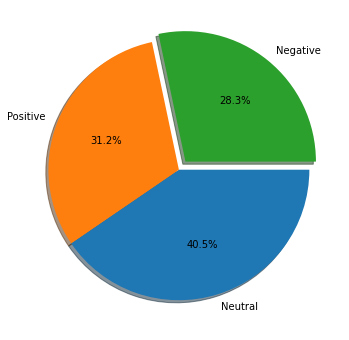

In [10]:
#Let us first analyze the distribution of the target variable

print('\033[1mTarget Variable Distribution'.center(55))
plt.pie(df[target].value_counts(), labels=['Neutral','Positive','Negative'], counterclock=False, shadow=True, 
        explode=[0,0,0.08], autopct='%1.1f%%', radius=1, startangle=0)
plt.show()

**Inference:** The Target Variable seems to be slightly imbalanced!

100%|██████████| 27480/27480 [00:08<00:00, 3347.57it/s]


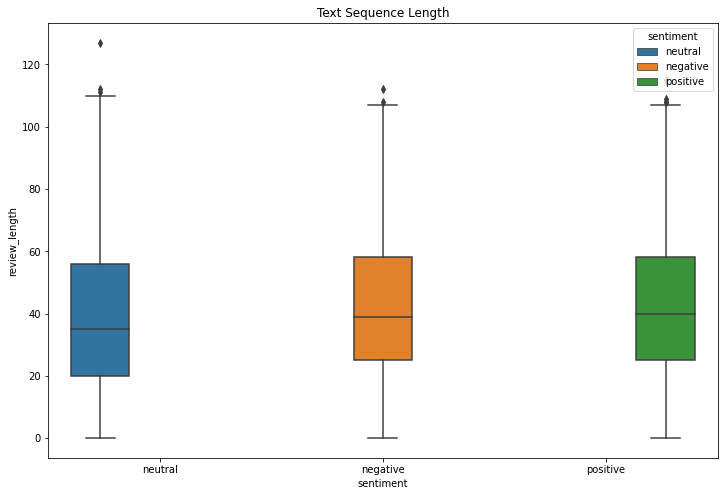

In [11]:
# Visualising the average text sequence length

df2 = df.copy()
df2['review_length'] = 0

for i in tqdm(range(df.shape[0])):
    df2['review_length'][i] = len(df2['text'][i])

plt.figure(figsize=[12,8])
sns.boxplot(x=target,y='review_length', data=df2, hue=target)
plt.title('Text Sequence Length')
plt.show()

**Inference:** The sequence length for reviews on an average are almost similiar through positive, negative & neutral tweets.

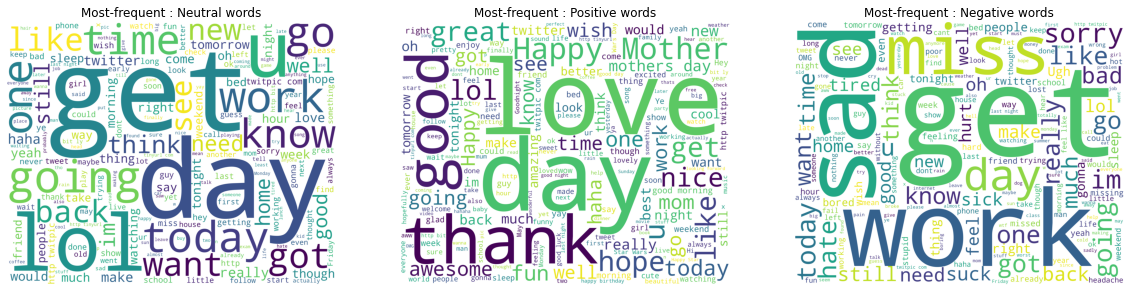

In [12]:
#Visualising the 

neutraldata = original_df[original_df[target]=='neutral']
neutraldata= neutraldata['text']
positivedata = original_df[original_df[target]=='positive']
positivedata =positivedata['text']
negdata = original_df[original_df[target]== 'negative']
negdata = negdata['text']


def wordcloud_draw(data, color, s):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split() if(word!='movie' and word!='film')])
    wordcloud = WordCloud(stopwords=stopwords.words('english'),background_color=color,width=2500,height=2000).generate(cleaned_word)
    plt.imshow(wordcloud)
    plt.title(s)
    plt.axis('off')

plt.figure(figsize=[20,10])
plt.subplot(1,3,1)
wordcloud_draw(neutraldata,'white','Most-frequent : Neutral words')

plt.subplot(1,3,2)
wordcloud_draw(positivedata,'white','Most-frequent : Positive words')

plt.subplot(1,3,3)
wordcloud_draw(negdata, 'white','Most-frequent : Negative words')
plt.show()

---

## <center> 4. Predictive Modeling

In [13]:
# Assigning labels to target variable

MAP={'negative':0, 'neutral':1, 'positive':2}
df.sentiment = df.sentiment.map(MAP)

In [14]:
#Splitting the data intro training & testing sets

X = x
Y = pd.Series(y).map(MAP)
MAP={'negative':0, 'neutral':1, 'positive':2}
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

print('Original set  ---> ',X.shape,len(Y),'\nTraining set  ---> ',Train_X.shape,len(Train_Y),'\nTesting set   ---> ', Test_X.shape,'', len(Test_Y))

Original set  --->  (27480, 22569) 27480 
Training set  --->  (21984, 22569) 21984 
Testing set   --->  (5496, 22569)  5496


In [15]:
#Let us create first create a table to store the results of various models 

Evaluation_Results = pd.DataFrame(np.zeros((4,5)), columns=['Accuracy', 'Precision','Recall','F1-score','AUC-ROC score'])
Evaluation_Results.index=['Logistic Regression (LR)','Decision Tree Classifier (DT)','Random Forest Classifier (RF)','Naïve Bayes Classifier (NB)']
Evaluation_Results

,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Logistic Regression (LR),0.0,0.0,0.0,0.0,0.0
Decision Tree Classifier (DT),0.0,0.0,0.0,0.0,0.0
Random Forest Classifier (RF),0.0,0.0,0.0,0.0,0.0
Naïve Bayes Classifier (NB),0.0,0.0,0.0,0.0,0.0


In [16]:
#Let us define functions to summarise the Prediction's scores .

from scikitplot.metrics import plot_roc_curve as auc_roc

#Classification Summary Function
def Classification_Summary(pred,pred_prob,i):
    Evaluation_Results.iloc[i]['Accuracy']=round(accuracy_score(Test_Y, pred),3)*100   
    Evaluation_Results.iloc[i]['Precision']=round(precision_score(Test_Y, pred, average='weighted'),3)*100 #, average='weighted'
    Evaluation_Results.iloc[i]['Recall']=round(recall_score(Test_Y, pred, average='weighted'),3)*100 #, average='weighted'
    Evaluation_Results.iloc[i]['F1-score']=round(f1_score(Test_Y, pred, average='weighted'),3)*100 #, average='weighted'
    Evaluation_Results.iloc[i]['AUC-ROC score']=round(roc_auc_score(Test_Y, pred_prob, multi_class='ovr'),3)*100 #, multi_class='ovr'
    print('{}{}\033[1m Evaluating {} \033[0m{}{}\n'.format('<'*3,'-'*35,Evaluation_Results.index[i], '-'*35,'>'*3))
    print('Accuracy = {}%'.format(round(accuracy_score(Test_Y, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(Test_Y, pred, average='weighted'),3)*100)) #, average='weighted'
    print('\n \033[1mConfusiton Matrix:\033[0m\n',confusion_matrix(Test_Y, pred))
    print('\n\033[1mClassification Report:\033[0m\n',classification_report(Test_Y, pred))
    
    auc_roc(Test_Y, pred_prob, curves=['each_class'])
    plt.show()

#Visualising Function
def AUC_ROC_plot(Test_Y, pred):    
    ref = [0 for _ in range(len(Test_Y))]
    ref_auc = roc_auc_score(Test_Y, ref)
    lr_auc = roc_auc_score(Test_Y, pred)

    ns_fpr, ns_tpr, _ = roc_curve(Test_Y, ref)
    lr_fpr, lr_tpr, _ = roc_curve(Test_Y, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='AUC = {}'.format(round(roc_auc_score(Test_Y, pred)*100,2))) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

---

## 1. Logistic Regression:

<<<----------------------------------- Evaluating Logistic Regression (LR) ----------------------------------->>>

Accuracy = 68.2%
F1 Score = 68.10000000000001%

 Confusiton Matrix:
 [[ 863  558  102]
 [ 277 1724  274]
 [  55  481 1162]]

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.57      0.64      1523
           1       0.62      0.76      0.68      2275
           2       0.76      0.68      0.72      1698

    accuracy                           0.68      5496
   macro avg       0.70      0.67      0.68      5496
weighted avg       0.69      0.68      0.68      5496



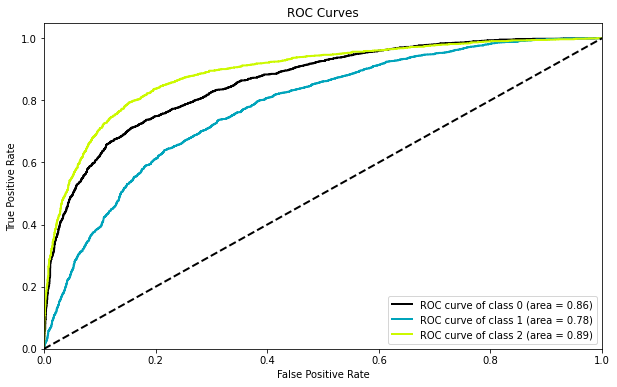

In [17]:
# Building Logistic Regression Classifier

LR_model = LogisticRegression()
LR = LR_model.fit(Train_X, Train_Y)
pred = LR.predict(Test_X)
pred_prob = LR.predict_proba(Test_X)
Classification_Summary(pred,pred_prob,0)

---

## 2. Decisoin Tree Classfier:

<<<----------------------------------- Evaluating Decision Tree Classifier (DT) ----------------------------------->>>

Accuracy = 65.2%
F1 Score = 65.2%

 Confusiton Matrix:
 [[ 910  456  157]
 [ 442 1460  373]
 [ 118  366 1214]]

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.60      0.61      1523
           1       0.64      0.64      0.64      2275
           2       0.70      0.71      0.71      1698

    accuracy                           0.65      5496
   macro avg       0.65      0.65      0.65      5496
weighted avg       0.65      0.65      0.65      5496



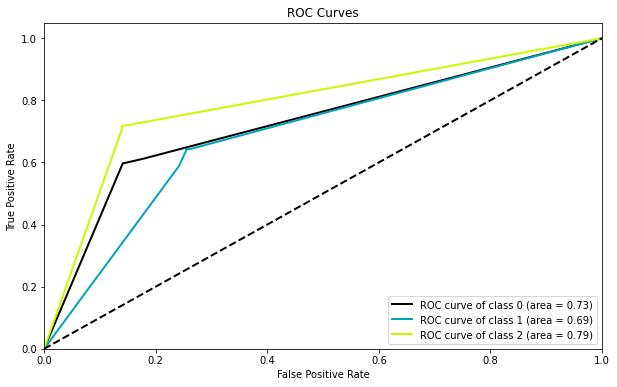

In [18]:
# Building Decision Tree Classifier

DT_model = DecisionTreeClassifier()
DT = DT_model.fit(Train_X, Train_Y)
pred = DT.predict(Test_X)
pred_prob = DT.predict_proba(Test_X)
Classification_Summary(pred,pred_prob,1)

---

## 3. Random Forest Classfier:

<<<----------------------------------- Evaluating Random Forest Classifier (RF) ----------------------------------->>>

Accuracy = 69.5%
F1 Score = 69.39999999999999%

 Confusiton Matrix:
 [[ 876  528  119]
 [ 262 1687  326]
 [  52  388 1258]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.58      0.65      1523
           1       0.65      0.74      0.69      2275
           2       0.74      0.74      0.74      1698

    accuracy                           0.70      5496
   macro avg       0.71      0.69      0.69      5496
weighted avg       0.70      0.70      0.69      5496



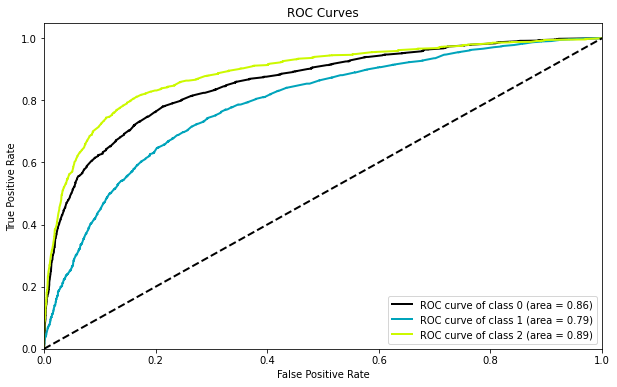

In [19]:
# Building Random Forest Classifier

RF_model = RandomForestClassifier()
RF = RF_model.fit(Train_X, Train_Y)
pred = RF.predict(Test_X)
pred_prob = RF.predict_proba(Test_X)
Classification_Summary(pred,pred_prob,2)

---

## 4. Naive Bayes Classfier:

<<<----------------------------------- Evaluating Naïve Bayes Classifier (NB) ----------------------------------->>>

Accuracy = 63.5%
F1 Score = 62.8%

 Confusiton Matrix:
 [[ 658  781   84]
 [ 199 1802  274]
 [  63  607 1028]]

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.43      0.54      1523
           1       0.56      0.79      0.66      2275
           2       0.74      0.61      0.67      1698

    accuracy                           0.63      5496
   macro avg       0.67      0.61      0.62      5496
weighted avg       0.66      0.63      0.63      5496



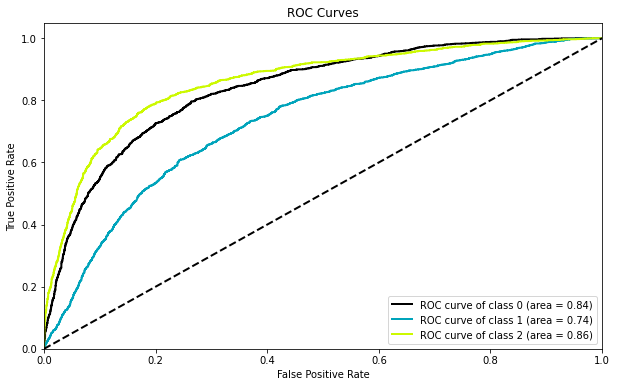

In [20]:
# Building Naive Bayes Classifier

NB_model = BernoulliNB()
NB = NB_model.fit(Train_X, Train_Y)
pred = NB.predict(Test_X)
pred_prob = NB.predict_proba(Test_X)
Classification_Summary(pred,pred_prob,3)

---

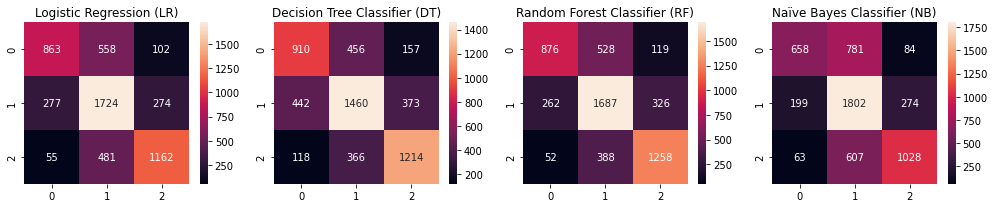

In [21]:
#Plotting Confusion-Matrix of all the predictive Models

labels=['Positive','Negative']
def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.columns=labels
    cm.index=labels
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    #fig, ax = plt.subplots()
    sns.heatmap(cm, annot=annot, fmt='')# cmap= "GnBu"
    
def conf_mat_plot(all_models):
    plt.figure(figsize=[14,3*math.ceil(len([all_models])/4)])
    
    for i in range(len(all_models)):
        if len(labels)<=4:
            plt.subplot(1,4,i+1)
        else:
            plt.subplot(math.ceil(len(all_models)/2),2,i+1)
        pred = all_models[i].predict(Test_X)
        #plot_cm(Test_Y, pred)
        sns.heatmap(confusion_matrix(Test_Y, pred), annot=True, fmt='.0f') #vmin=0,vmax=5,cmap='BuGn'
        plt.title(Evaluation_Results.index[i])
    plt.tight_layout()
    plt.show()

conf_mat_plot([LR,DT,RF,NB])

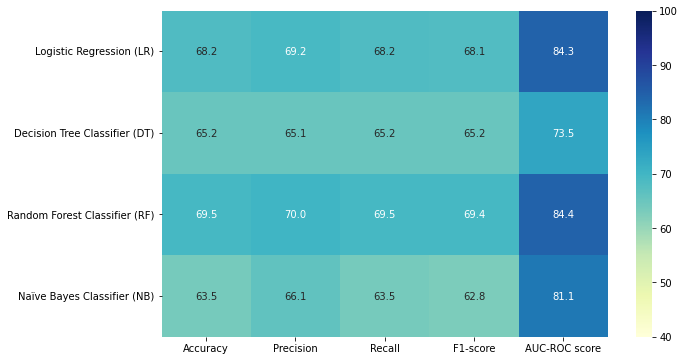

In [22]:
#Comparing all the models Scores

#plt.figure(figsize=[12,5])
sns.heatmap(Evaluation_Results, annot=True, vmin=40, vmax=100.0, cmap='YlGnBu', fmt='.1f')
plt.show()

**Insights:** For the current problem statement, it is more important to focus on the F1-score. Random Forest Classifier performs the best on the current dataset. Yet it's performance can be increase further by fine-tuning the parameters.(we'll skip it for now due to computational limitations)...

---

## <center> 5. Project Outcomes & Conclusions

### Here are some of the key outcomes of the project:
- The Dataset was large enough totally around 27481 samples & preprocessing was done to clean the samples. 
- The positive, neutral & negative reviews were somewhat equally distributed.
- Visualising the distribution of data & their relationships, helped us to get some insights on the sparse matrix distribution.
- Testing multiple algorithms with default hyperparamters gave us some understanding for various models performance on this specific dataset.
- Random Forest Classifier performed the best on the current dataset with the highest F1-score. It's performance could be further improved by fintuning the hyperparmeters.
- Yet it is wise to also consider simpler models like Logisitic Regression as it is more generalisable & computationally less expensive.

In [23]:
<<<----------------------------------------------------THE END------------------------------------------------------------->>>

SyntaxError: invalid syntax (2640489763.py, line 1)